In [20]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['figure.figsize'] = 12,8

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy.ma as ma
from scipy.optimize import curve_fit

In [21]:
def get_data(file_name):
    data = np.genfromtxt(file_name, dtype=float, delimiter=None,
                         skip_header=2, names=["Qx", "Qy", "I(Qx,Qy)", "err(I)"])
    shape_x = len(np.unique(data['Qx']))
    shape_y = len(np.unique(data['Qy']))
    data_x = data['Qx']  # .reshape(shape_x, shape_y)
    data_y = data['Qy']  # .reshape(shape_x, shape_y)
    data_z = data['IQxQy']  # .reshape(shape_x, shape_y)
    return data_x, data_y, data_z

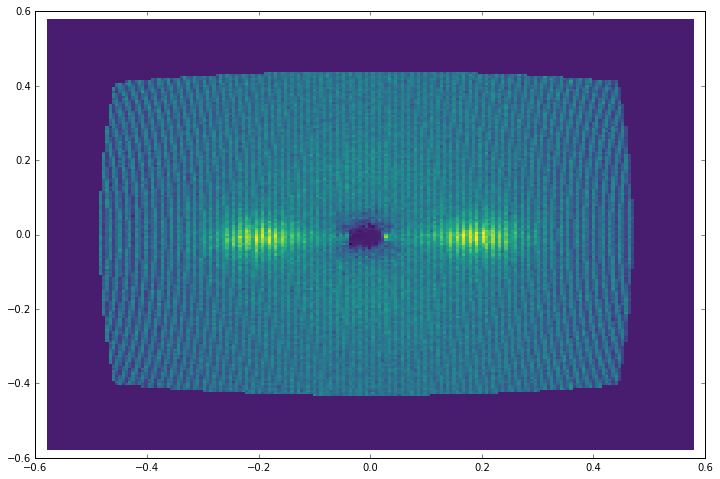

In [22]:
data_x, data_y, data_z = get_data("./Bio-SANS/anisotropy_with-peak/high-q-has_peak/BioSANS_exp317_scan0021_0001_Iqxy.dat")

# Raw image
shape_x = len(np.unique(data_x))
shape_y = len(np.unique(data_y))
X = data_x.reshape(shape_x, shape_y)
Y = data_y.reshape(shape_x, shape_y)
Z = data_z.reshape(shape_x, shape_y)
plt.pcolormesh(X, Y, Z)


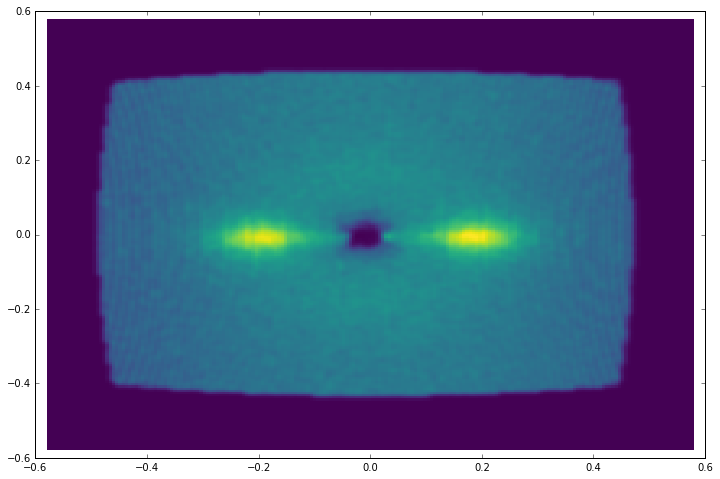

In [23]:
# Image smoothing to get rid of the stripes
from scipy.ndimage import filters
Z_smooth = filters.gaussian_filter(Z, sigma=1)
plt.pcolormesh(X, Y, Z_smooth)

In [24]:
def sector_average(data_x, data_y, data_z, 
                   n_bins_angle=100, n_bins_radius=50, max_radius = np.inf):
    
    radius = np.linalg.norm(np.column_stack((data_x, data_y)), axis=1)

    angle = np.arctan2(data_y, data_x)
    angle = np.rad2deg(angle)
    # make it integer from 0 to 360
    angle = np.round(angle).astype(int) + 180

    angle = angle[radius <= max_radius]
    # radius for every pixel

    # normalize data to 1
    data_z = (data_z - data_z.min()) / (data_z.max() - data_z.min())
    data_z = (data_z)**(1/2)
    data_z =data_z[radius <= max_radius]
    radius = radius[radius <= max_radius]

    H, xedges, yedges, binnumber = stats.binned_statistic_2d(angle, radius, data_z,
                                       bins=[n_bins_angle, n_bins_radius],
                                       statistic='mean')

    xedges_width = (xedges[1] - xedges[0])
    xedges_center = xedges[1:] - xedges_width / 2

    yedges_width = (yedges[1] - yedges[0])
    yedges_center = yedges[1:] - yedges_width / 2

    xedges_center = np.linspace(np.amin(xedges_center), np.amax(xedges_center), len(xedges_center))

    return H, xedges_center, yedges_center


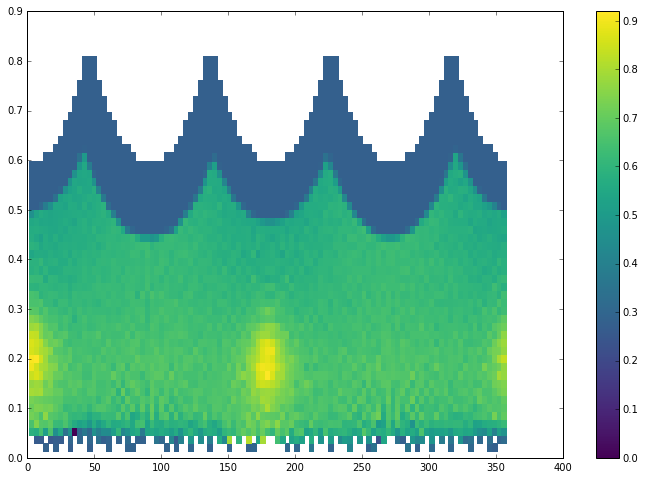

In [25]:
# Sectors
H, x, y = sector_average(data_x, data_y, data_z)
X_sectors, Y_sectors = np.meshgrid(x, y)
H_masked_nans = ma.masked_where(np.isnan(H),H)
plt.pcolormesh(X_sectors, Y_sectors, H_masked_nans.T)
plt.colorbar()

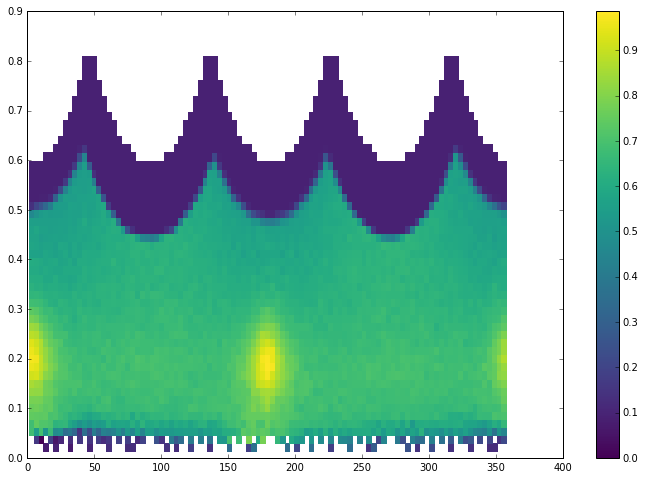

In [26]:
# Let's do the same with smoothing
# Sectors
from scipy.ndimage import filters
data_z_smooth = filters.gaussian_filter(data_z, sigma=1)

H, x, y = sector_average(data_x, data_y, data_z_smooth)
X_sectors, Y_sectors = np.meshgrid(x, y)
H_masked_nans = ma.masked_where(np.isnan(H),H)
plt.pcolormesh(X_sectors, Y_sectors, H_masked_nans.T)
plt.colorbar()

In [27]:
from scipy.ndimage import filters
data = H.T

In [28]:
neighborhood_size = 30
data_max = filters.maximum_filter(data, neighborhood_size)
#plt.imshow(data_max,origin='lower')

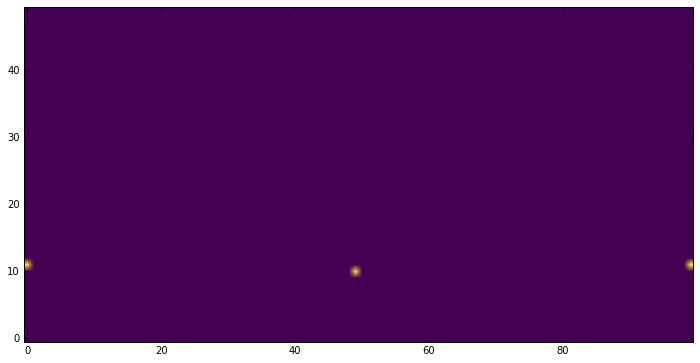

In [29]:
# Plot Maximumns found for the neighborhood_size
cond = data_max==data
plt.imshow(cond,origin='lower')

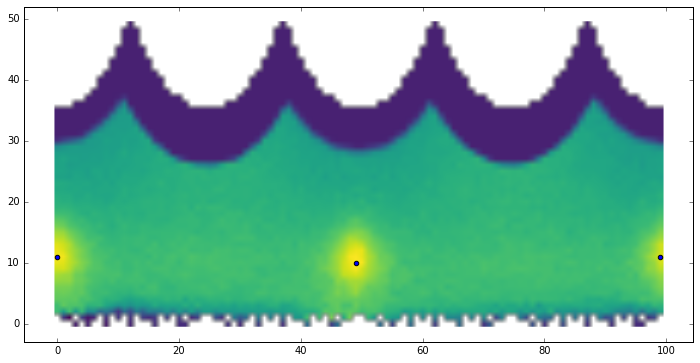

In [30]:
# Overlay Maximum indices over the plot
indices = cond.nonzero()
plt.imshow(data,origin='lower')
plt.scatter(indices[1],indices[0])


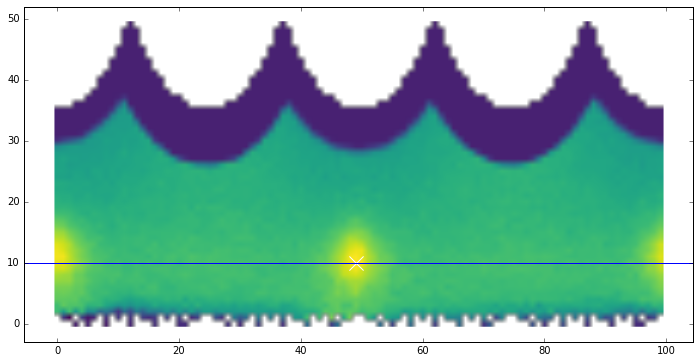

In [31]:
# From the maxiums, find the maximum value!
values = np.where(cond, data, -1) 
indice_of_max = np.unravel_index(np.argmax(values),values.shape)
plt.imshow(data,origin='lower')
plt.scatter(indice_of_max[1],indice_of_max[0],color='white',marker='x', s= 200)
plt.axhline(y=indice_of_max[0])

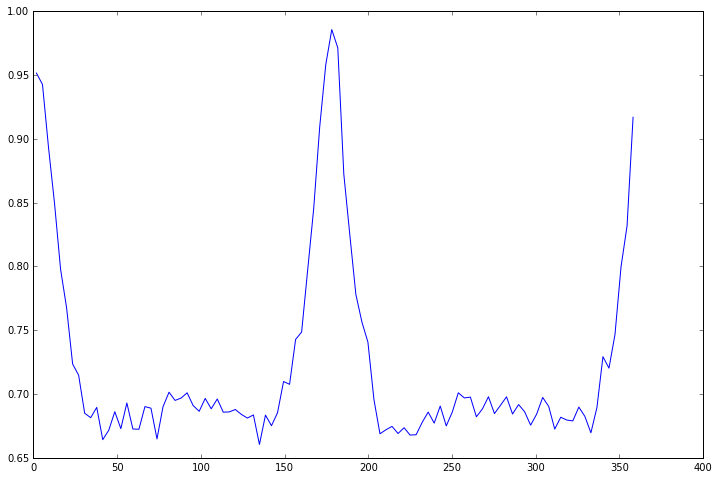

In [32]:
horizontal_cut = data[indice_of_max[0],:]
plt.plot(x,horizontal_cut)

In [33]:
# Define model function to be used to fit to the data later:
def gauss(x, *p):
    A, mu, sigma, base = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + base

[   0.28542068  177.63824895   10.17608087    0.68583118]


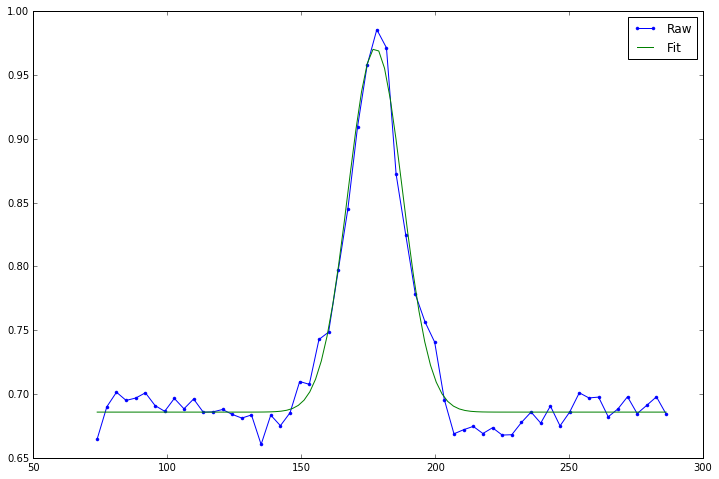

In [34]:
# get rid of both ends
x_trimmed = x[20:-20]
horizontal_cut_trimmed = horizontal_cut[20:-20]

max_idx = np.argmax(horizontal_cut_trimmed)

# p0 is the initial guess for the fitting coefficients (A, mu, sigma, vertical offset)
p0 = [0.5, x_trimmed[max_idx], 5, 0.4]



coeff, var_matrix = curve_fit(gauss, x_trimmed, horizontal_cut_trimmed, p0=p0)


x_fit = np.linspace(x_trimmed[0],x_trimmed[-1],100)
# Get the fitted curve
fit = gauss(x_fit, *coeff)


plt.plot(x_trimmed, horizontal_cut_trimmed, marker='.', label='Raw')
plt.plot(x_fit, fit, label='Fit')
plt.legend()
print(coeff)

In [35]:
print("A = {:4,.2f}, mu = {:4,.2f}, sigma = {:4,.2f}, vertical offset = {:4,.2f}".format(*coeff))

A = 0.29, mu = 177.64, sigma = 10.18, vertical offset = 0.69


In [36]:
def fwhm(sigma):
    '''
    Full width at half maximum
    '''
    return 2 * np.sqrt(2*np.log(2))*sigma

fwhm_value = fwhm(coeff[2])
print(fwhm_value)

23.9628392231


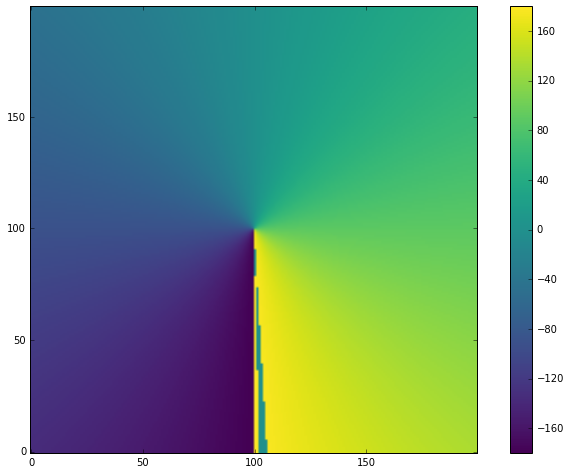

In [55]:
#
# Todo! Plot the coeffs
#
angle = np.arctan2(X,Y)
angle = np.rad2deg(angle)
#plt.pcolormesh(X, Y, angle)

angle[(angle > coeff[1] - 1) & (angle < coeff[1] + 1)] = 0
plt.imshow(angle,origin='lower')
plt.colorbar()

# Annulus

2 concentric circles... different approach!


In [38]:
def annulus(data_x, data_y, data_z, 
                   n_bins=100, min_radius=0.1, max_radius = 0.3):
    
    radius = np.linalg.norm(np.column_stack((data_x, data_y)), axis=1)

    angle = np.arctan2(data_y, data_x)
    angle = np.rad2deg(angle)
    # make it integer from 0 to 360
    angle = np.round(angle).astype(int) + 180
    
    radius_condition = (radius <= max_radius) & (radius >= min_radius)
    angle = angle[radius_condition]
    
    # normalize data to 1
    data_z = (data_z - data_z.min()) / (data_z.max() - data_z.min())
    data_z = data_z[radius_condition]
    
    H, edges, binnumber = stats.binned_statistic(angle, data_z,
                                       bins=n_bins,statistic='mean')

    edges_width = (edges[1] - edges[0])
    edges_center = edges[1:] - edges_width / 2

    edges_center = np.linspace(np.amin(edges_center), np.amax(edges_center), len(edges_center))

    return H, edges_center

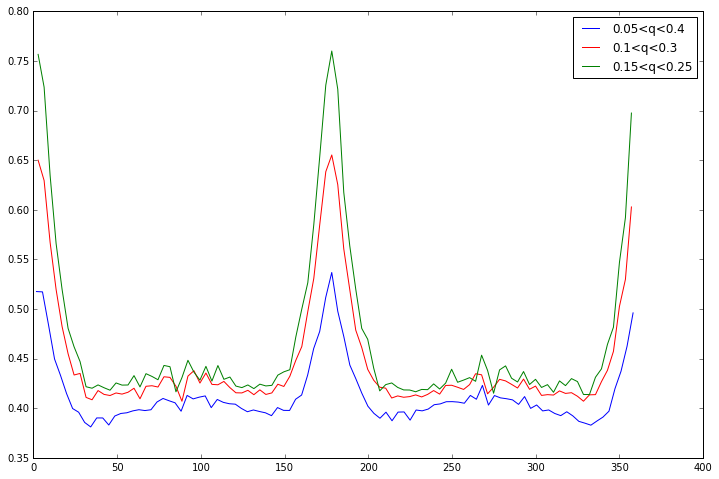

In [39]:
# annulus (bins in between 2 circles)
H, x = annulus(data_x, data_y, data_z,n_bins=100, min_radius=0.05, max_radius = 0.4)
plt.plot(x,H,c='b',label="0.05<q<0.4")
H, x = annulus(data_x, data_y, data_z,n_bins=100, min_radius=0.1, max_radius = 0.3)
plt.plot(x,H,c='r',label="0.1<q<0.3")
H, x = annulus(data_x, data_y, data_z,n_bins=100, min_radius=0.15, max_radius = 0.25)
plt.plot(x,H,c='g',label="0.15<q<0.25")
plt.legend()

[   0.29763587  177.63516868    8.29327177    0.44889979]


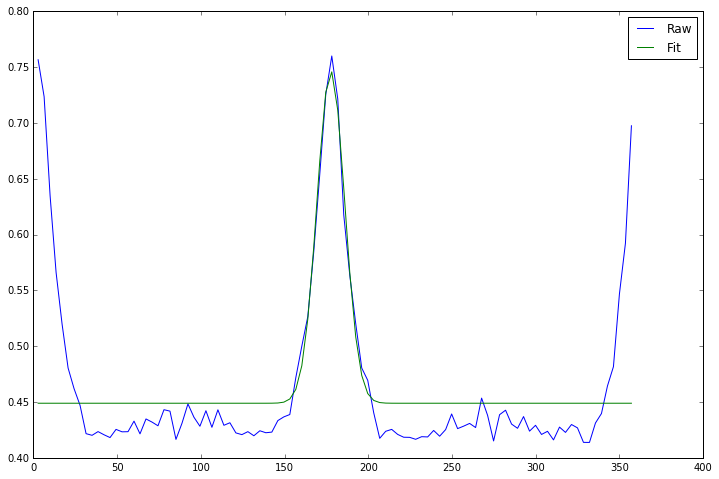

In [40]:
# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [0.4, 180., 5, 0.4]

coeff, var_matrix = curve_fit(gauss, x, H, p0=p0)

# Get the fitted curve
fit = gauss(x, *coeff)


plt.plot(x, H, label='Raw')
plt.plot(x, fit, label='Fit')
plt.legend()
print(coeff)